# Data processing of African Easterly Waves tracks
### AOS573 Final Project
### Kayleen Torres-Maldonado


This project does not consist of a specific research question or testing a hypothesis, but more of a process of how to clean and prepare the data that I will be using for my current graduate research project. The main goal of this class project is to make the data more accessible and usable by putting all the data files in one place, separating and cleaning the data, and subselecting the most relevant parameters. 

The process that I will be presenting in this project is just the first step of my current research, and that is why I am using it as an opportunity to move my graduate research forward. The final goal of the research project is to analyze the development of African Easterly Waves (AEWs) into tropical cyclones (TCs) using AEWs tracks from 1979 to 2017. The tracks need to be separated into two categories: events that developed (DAEWs), and events that did not develop (NDAEWs). This step is the most important and it will be tha main focus of this class project. Once the tracks are separated they can be used to perform the relative analyses of the research project. 


#### Let's first import all the packages that will be necessary! Most of these were used during the semester for homeworks and class notebooks.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tarfile
import xarray as xr
import math
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import matplotlib.gridspec as gridspec

#### Background information of the data:
The data to be used is based on the AEW tracking methods of Brammer et al. (2018) and was created combining the National Centers for Environmental Prediction CFSR v2 and ECMWF interim reanalysis (ERA-interim). This data was also used and modified by Dr. Kelly Nuñez Ocasio (2021) which conducted a very similar project using AEW tracks. The data was obtained directly from Dr. Nuñez Ocasio.


The data consists of yearly files of AEW tracks from 1979 to 2017 for the months of June to October. Each year contain different number of events (ids) which have to be separated between developers and nondevelopers. 

I understand that many of the steps made here could be done in shorter and more compact code. However, I want to be able to document in detail the steps that I am taking so I am breaking them down in different parts.

### Part 1) Opening and understanding the data

#### Let's load in just one year file of the data to see how it is structured!

Make sure you cd into the directory were the data is stored.

In [2]:
#Using the year 2017 as an example
ds_2017 = xr.open_dataset('ym_matched_tracks/2017_erai_pregen_tracks.nc')
ds_2017

<xarray.Dataset>
Dimensions:      (id: 199, time: 612)
Coordinates:
  * id           (id) int32 0 1 2 3 4 5 6 7 ... 191 192 193 194 195 196 197 198
  * time         (time) datetime64[ns] 2017-06-01 ... 2017-10-31T18:00:00
Data variables:
    track_val    (id, time) float32 ...
    track_lat    (id, time) float32 ...
    track_lon    (id, time) float32 ...
    storm_names  (id) object ...
    storm_type   (id, time) object ...

#### Information about the dataset:

Variables:
- track_val: tracking values of relative vorticity
- track_lon: tracks longitudes
- track_lat: tracks latitudes
- storm_names: This only applies to the events underwent cyclogenesis
- storm_type: The type of storm(TD, TS, Hurricane)

Coordinates:
- id: each id represents a AEW event, independently if it developed or not
- time: data every six hours. From June 1st through October 31st.

Dimensions:
- id: for this particular example there are 199 events (id). Every year will have a different dimension
- time: 612 

#### Important to note:

- One of the things that make these datasets challenging to work with is that the longitudes and latitudes are not coordinates, but variables. This is because the longitudes and latitudes will change for each event, and therefore is not fixed. 

- Each id represents an AEW event. Every specific id has a tracking value of relative vorticity, longitude, and latitude associated to it. 

- The storm_names variable has only coordinates of id, which means that every id has a storm_name. If the event did not developed, then the storm_name is filled with a nan. Only events that developed have storm_names. (See cell below)


In [3]:
#Storm_names variable
ds_2017.storm_names

#There are only 4 named events in 2017

<xarray.DataArray 'storm_names' (id: 199)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       b'AL082017', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, b'AL112017', nan, nan, b'AL122017', nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, b'AL142017',
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)
Coordinates:
  * id       (id) int32 0 1 2 3 4 5 6 7 8 ... 191 192 193 194 195 196 197 198

### Part 2) Separating the nondeveloper from the developer events.

#### Next steps:
1. Open every file at once.
2. Change the format of the variables. All the nan values have to be chaged to empty strings.
3. Obtain the ids of the developing events and the nondeveloping events and save them in two different arrays. 

In [4]:
#The year time range is from 1979 to 2017
years = np.arange(1979,2018,1)

#Creating two new arrays that separate the events that developed from the ones that did not develop
DAEW = [] #empty arrays
NDAEW = []

#This for loop opens all the files at once, fill the nans with '', and create two new arrays

for i in np.arange(0,39,1): #there is a total of 39 years
    fname= "ym_matched_tracks/"+str(years[i])+"_erai_pregen_tracks.nc"
    ds=xr.open_dataset(fname) #opening the file
    
    #Filling the nan values with empty strings
    ds['storm_names'] = ds["storm_names"].fillna('') 
    ds['storm_names'] = ds['storm_names'].astype('U13')
    
    ds['track_val'] = ds["track_val"].fillna('') 
    ds['track_val'] = ds['track_val'].astype('U13') 
    
    ds['track_lon'] = ds["track_lon"].fillna('') 
    ds['track_lon'] = ds['track_lon'].astype('U13')
    
    ds['track_lat'] = ds["track_lat"].fillna('') 
    ds['track_lat'] = ds['track_lat'].astype('U13')
    
    ds['storm_type'] = ds["storm_type"].fillna('') 
    ds['storm_type'] = ds['storm_type'].astype('U13')
    
    #Here we separate the data in the two arrays
    dev = ds.where(ds.storm_names!='',drop=True) #Dropping the empty spaces (events that didn't develop)
    DAEW.append(dev) #append to the empty array
    
    nondev = ds.where(ds.storm_names=='',drop=True) #Dropping the named events (that developed)
    NDAEW.append(nondev)
    

##### Let's see how these new datasets look like

In [5]:
#Printint just the frist year 1979
print(DAEW[0])
print()
print(NDAEW[0])

<xarray.Dataset>
Dimensions:      (id: 5, time: 612)
Coordinates:
  * id           (id) int32 98 101 105 109 117
  * time         (time) datetime64[ns] 1979-06-01 ... 1979-10-31T18:00:00
Data variables:
    track_val    (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    track_lat    (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    track_lon    (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    storm_names  (id) object 'AL091979' 'AL131979' ... 'AL141979' 'AL161979'
    storm_type   (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''

<xarray.Dataset>
Dimensions:      (id: 166, time: 612)
Coordinates:
  * id           (id) int32 0 1 2 3 4 5 6 7 ... 163 164 165 166 167 168 169 170
  * time         (time) datetime64[ns] 1979-06-01 ... 1979-10-31T18:00:00
Data variables:
    track_val    (id, time) object '' '' ... '5.49550350115' '7.54830443838'
    track_lat    (id, time) object '6.57059812545' ... '15.4357585906'
    track

Notice how the dimensions of the DAEW dataset id changed to only 5. This is because we were able to separate the events that developed and in this particular year, there were only 5 AEWs that developed into a tropical cyclone. This is good! Now we have DAEWs and NDAEWs ids separated.

#### Next step:
- Obtain the specific id numbers associated with developers and nondevelopers for each year.
- With this id number then I will be able to get the tracks for DAEWs and NDAEWs.

In [6]:
#Get the id number
DAEW_ids = []
NDAEW_ids = []
for i in np.arange(0,39,1):
    
    dev_ids = DAEW[i].id
    DAEW_ids.append(dev_ids)
    
    nondev_ids = NDAEW[i].id
    NDAEW_ids.append(nondev_ids)

In [7]:
#This is how it looks for the year 1979
# It gives an array with the id numbers of every developer
DAEW_ids[0]

<xarray.DataArray 'id' (id: 5)>
array([ 98, 101, 105, 109, 117], dtype=int32)
Coordinates:
  * id       (id) int32 98 101 105 109 117

#### Next step:
- With the id number we can obtain the DAEW and NDAEW tracks separately for each year.
- Because it will give each year as a differen xarray, we will want to concatenate the data so it merges all the years into one xarray dataset. 

In [8]:
year = 1978 #Starting year. One year will be added every time it goes over the for loop
name_holder_dev = {} #This is an empty array that will be used to update the name of the variables
name_holder_nondev = {}

for i in np.arange(0,39,1):
    year = year + 1
    name_holder_dev['DAEW_tracks_' + str(year)] = [] #empty array with name of  developer dataset
    name_holder_nondev['NDAEW_tracks_' + str(year)] = []
    
    #Developers
    for x in DAEW_ids[i].values: 
        var1 = DAEW[i].sel(id=x)
        name_holder_dev['DAEW_tracks_' + str(year)].append(var1)
    #Nondevelopers
    for x in NDAEW_ids[i].values: 
        var2 = NDAEW[i].sel(id=x)
        name_holder_nondev['NDAEW_tracks_' + str(year)].append(var2)
    
    #There are two years that there weren't any developers: 1992 and 1997
    #So we have to create a condition that omits these two years
    if name_holder_dev['DAEW_tracks_' + str(year)] == []:
        locals().update(name_holder_dev)
        continue
    #Concatenate into one datase per year
    else:
        name_holder_dev['DAEW_tracks_' + str(year)] = xr.concat(name_holder_dev['DAEW_tracks_' + str(year)], dim='id', data_vars='all', coords='different')
        name_holder_nondev['NDAEW_tracks_' + str(year)] = xr.concat(name_holder_nondev['NDAEW_tracks_' + str(year)], dim='id', data_vars='all', coords='different')
    locals().update(name_holder_dev) #This updates the changing variable
    locals().update(name_holder_nondev)
    

##### Let's see how the final tracks datasets look like

In [9]:
#For the year 2017
print(DAEW_tracks_2017)
print()
print(NDAEW_tracks_2017)

<xarray.Dataset>
Dimensions:      (id: 4, time: 612)
Coordinates:
  * time         (time) datetime64[ns] 2017-06-01 ... 2017-10-31T18:00:00
  * id           (id) int64 83 113 116 133
Data variables:
    track_val    (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    track_lat    (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    track_lon    (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    storm_names  (id) object 'AL082017' 'AL112017' 'AL122017' 'AL142017'
    storm_type   (id, time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''

<xarray.Dataset>
Dimensions:      (id: 195, time: 612)
Coordinates:
  * time         (time) datetime64[ns] 2017-06-01 ... 2017-10-31T18:00:00
  * id           (id) int64 0 1 2 3 4 5 6 7 ... 191 192 193 194 195 196 197 198
Data variables:
    track_val    (id, time) object '1.36584521897' ... '5.46347746421'
    track_lat    (id, time) object '3.83381032943' ... '17.1383991241'
    track_lon    (id, t

- We now get a dataset for DAEWs and NDAEWs tracks for each year. 

- These datasets will retain the coordinates of id and time.

- For the year of 2017, there were 4 developers and 195 nondevelopers. 

- It is important to note that there are only values of vorticity, longitude, and latitude for the specific times that the system existed. Therefore, outside of that time there are only empty strings. This is an issue that we will deal later

### Part 3) Plot the tracks to verify if they are accurate.

##### Now that we have the yearly tracks for DAEWs and NDAEWs, it is important to see how they look plotted to make sure they make sense and that no mistakes were made when separating the data.

##### Because values of vorticity, longitude, and latitude are available only for the times when the AEW existed, we have to eliminate those empty strings. This needs to be taken care here.

Only five years will be plotted (2005-2009).

*I guess this could be done in a shorter code, but I wasn't able to make it work*


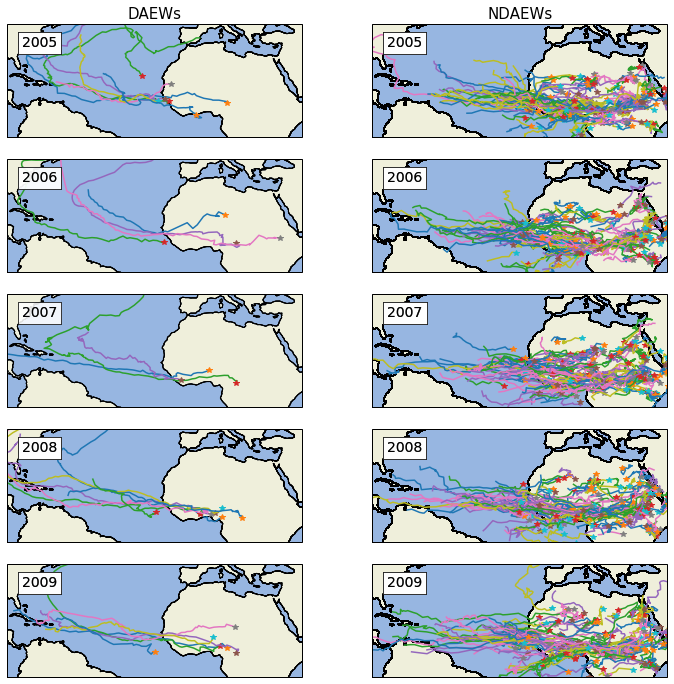

In [10]:
#Plotting the tracks from 2005-2009
gs=gridspec.GridSpec(nrows=5,ncols=2) # 5 rows (for each year), 2 columns (DAEWs and NDAEWs)
fig=plt.figure(figsize=(12,12)) #figure size
props = dict(facecolor='white', alpha=0.5) #properties for year textbox
mpl.rcParams['font.family'] = 'sans-serif' #changing the font

#2005
## DAEWs
ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
for i in np.arange(0,len(DAEW_tracks_2005.id),1):
    #Here we drop the empy strings that corresponds to times outside of existing wave
    new_DAEW_tracks_2005=DAEW_tracks_2005.where(DAEW_tracks_2005.track_val[i]!='',drop=True)
    lon = list(reversed(new_DAEW_tracks_2005.track_lon[i].values.astype('float64'))) #reversing the longitudes and latitudes
    lat = list(reversed(new_DAEW_tracks_2005.track_lat[i].values.astype('float64')))

    ax.plot(lon,lat,transform=ccrs.PlateCarree())
    ax.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax.coastlines(color='k')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.text(0.05, 0.90, '2005', transform=ax.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax.set_title('DAEWs',fontsize=15)
    ax.set_extent([-86,45,-5,45],ccrs.PlateCarree())
        
## NDAEWs
ax1 = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
for i in np.arange(0,len(NDAEW_tracks_2005.id),1):
    new_NDAEW_tracks_2005=NDAEW_tracks_2005.where(NDAEW_tracks_2005.track_val[i]!='',drop=True)
    lon = list(reversed(new_NDAEW_tracks_2005.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_NDAEW_tracks_2005.track_lat[i].values.astype('float64')))

    ax1.plot(lon,lat,transform=ccrs.PlateCarree())
    ax1.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax1.coastlines(color='k')
    ax1.add_feature(cfeature.LAND)
    ax1.add_feature(cfeature.OCEAN)
    ax1.text(0.05, 0.90, '2005', transform=ax1.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax1.set_title('NDAEWs',fontsize=15)
    ax1.set_extent([-86,45,-5,45],ccrs.PlateCarree())


    
#2006
## DAEWs
ax2 = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
for i in np.arange(0,len(DAEW_tracks_2006.id),1):
    new_DAEW_tracks_2006=DAEW_tracks_2006.where(DAEW_tracks_2006.track_val[i]!='',drop=True)
    lon = list(reversed(new_DAEW_tracks_2006.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_DAEW_tracks_2006.track_lat[i].values.astype('float64')))

    ax2.plot(lon,lat,transform=ccrs.PlateCarree())
    ax2.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax2.coastlines(color='k')
    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.OCEAN)
    ax2.text(0.05, 0.90, '2006',transform=ax2.transAxes,verticalalignment='top',fontsize=14,bbox=props)
    ax2.set_extent([-86,45,-5,45],ccrs.PlateCarree())
    
## NDAEWs
ax3 = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
for i in np.arange(0,len(NDAEW_tracks_2006.id),1):
    new_NDAEW_tracks_2006=NDAEW_tracks_2006.where(NDAEW_tracks_2006.track_val[i]!='',drop=True)
    lon = list(reversed(new_NDAEW_tracks_2006.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_NDAEW_tracks_2006.track_lat[i].values.astype('float64')))

    ax3.plot(lon,lat,transform=ccrs.PlateCarree())
    ax3.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax3.coastlines(color='k')
    ax3.add_feature(cfeature.LAND)
    ax3.add_feature(cfeature.OCEAN)
    ax3.text(0.05, 0.90, '2006', transform=ax3.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax3.set_extent([-86,45,-5,45],ccrs.PlateCarree())



#2007
## DAEWs
ax4=fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree())
for i in np.arange(0,len(DAEW_tracks_2007.id),1):
    new_DAEW_tracks_2007=DAEW_tracks_2007.where(DAEW_tracks_2007.track_val[i]!='',drop=True)
    lon = list(reversed(new_DAEW_tracks_2007.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_DAEW_tracks_2007.track_lat[i].values.astype('float64')))

    ax4.plot(lon,lat,transform=ccrs.PlateCarree())
    ax4.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax4.coastlines(color='k')
    ax4.add_feature(cfeature.LAND)
    ax4.add_feature(cfeature.OCEAN)
    ax4.text(0.05, 0.90, '2007', transform=ax4.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax4.set_extent([-86,45,-5,45],ccrs.PlateCarree())

## NDAEWs
ax5=fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree())
for i in np.arange(0,len(NDAEW_tracks_2007.id),1):
    new_NDAEW_tracks_2007=NDAEW_tracks_2007.where(NDAEW_tracks_2007.track_val[i]!='',drop=True)
    lon = list(reversed(new_NDAEW_tracks_2007.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_NDAEW_tracks_2007.track_lat[i].values.astype('float64')))

    ax5.plot(lon,lat,transform=ccrs.PlateCarree())
    ax5.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax5.coastlines(color='k')
    ax5.add_feature(cfeature.LAND)
    ax5.add_feature(cfeature.OCEAN)
    ax5.text(0.05, 0.90, '2007', transform=ax5.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax5.set_extent([-86,45,-5,45],ccrs.PlateCarree())


    
#2008
## DAEWs
ax6=fig.add_subplot(gs[3,0],projection=ccrs.PlateCarree())
for i in np.arange(0,len(DAEW_tracks_2008.id),1):
    new_DAEW_tracks_2008=DAEW_tracks_2008.where(DAEW_tracks_2008.track_val[i]!='',drop=True)
    lon = list(reversed(new_DAEW_tracks_2008.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_DAEW_tracks_2008.track_lat[i].values.astype('float64')))

    ax6.plot(lon,lat,transform=ccrs.PlateCarree())
    ax6.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax6.coastlines(color='k')
    ax6.add_feature(cfeature.LAND)
    ax6.add_feature(cfeature.OCEAN)
    ax6.text(0.05, 0.90, '2008', transform=ax6.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax6.set_extent([-86,45,-5,45],ccrs.PlateCarree())

## NDAEWs
ax7=fig.add_subplot(gs[3,1],projection=ccrs.PlateCarree())
for i in np.arange(0,len(NDAEW_tracks_2008.id),1):
    new_NDAEW_tracks_2008=NDAEW_tracks_2008.where(NDAEW_tracks_2008.track_val[i]!='',drop=True)
    lon = list(reversed(new_NDAEW_tracks_2008.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_NDAEW_tracks_2008.track_lat[i].values.astype('float64')))

    ax7.plot(lon,lat,transform=ccrs.PlateCarree())
    ax7.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax7.coastlines(color='k')
    ax7.add_feature(cfeature.LAND)
    ax7.add_feature(cfeature.OCEAN)
    ax7.text(0.05, 0.90, '2008', transform=ax7.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax7.set_extent([-86,45,-5,45],ccrs.PlateCarree())

    
    
#2009
## DAEWs
ax8 = fig.add_subplot(gs[4,0],projection=ccrs.PlateCarree())
for i in np.arange(0,len(DAEW_tracks_2009.id),1):
    new_DAEW_tracks_2009=DAEW_tracks_2009.where(DAEW_tracks_2009.track_val[i]!='',drop=True)
    lon = list(reversed(new_DAEW_tracks_2009.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_DAEW_tracks_2009.track_lat[i].values.astype('float64')))

    ax8.plot(lon,lat,transform=ccrs.PlateCarree())
    ax8.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax8.coastlines(color='k')
    ax8.add_feature(cfeature.LAND)
    ax8.add_feature(cfeature.OCEAN)
    ax8.text(0.05, 0.90, '2009', transform=ax8.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax8.set_extent([-86,45,-5,45],ccrs.PlateCarree())    

## NDAEWs
ax9 = fig.add_subplot(gs[4,1],projection=ccrs.PlateCarree())
for i in np.arange(0,len(NDAEW_tracks_2009.id),1):
    new_NDAEW_tracks_2009=NDAEW_tracks_2009.where(NDAEW_tracks_2009.track_val[i]!='',drop=True)
    lon = list(reversed(new_NDAEW_tracks_2009.track_lon[i].values.astype('float64')))
    lat = list(reversed(new_NDAEW_tracks_2009.track_lat[i].values.astype('float64')))

    ax9.plot(lon,lat,transform=ccrs.PlateCarree())
    ax9.plot(lon[-1],lat[-1],'*',transform=ccrs.PlateCarree())
    ax9.coastlines(color='k')
    ax9.add_feature(cfeature.LAND)
    ax9.add_feature(cfeature.OCEAN)
    ax9.text(0.05, 0.90, '2009', transform=ax9.transAxes, fontsize=14, verticalalignment='top',bbox=props)
    ax9.set_extent([-86,45,-5,45],ccrs.PlateCarree())

#to save the figure
#plt.savefig('DAEW_NDAEW_tracs.png')

##### With these plots it was verified that the separated datasets make sense.

Now that this important data processing step is done, I am able proceed to the next steps. These tracks can be used to perform composite analyses of vertically-integrated moist static potential vorticity (MSPV), a variable that is hypothesized could potentially quantify the likelihood of tropical cyclogenesis. However, this analyses is not conducted for this class project given that the data processig took most of the time.